# Using *Moves* data to see whether cold/rain weather turns you into a couch potato

This notebook uses your GPS tracks from *Moves* to find out how much you walked each day and where. Your geo location is then used to identify the local weather (temperature & precipitation) on that day through the *Dark Sky* API to see whether the local weather influences how much you walk. 

To get started we just need to set three settings below:

`DARKSKY_KEY` is your own API key for Dark Sky. You can [create one for free on their website](https://darksky.net/dev). Dark Sky allows you to make 1,000 calls per day for free. This notebook makes at worst 1 call for each day that is in your `DATARANGE`. So the 1,000 calls can get you ~ 2 1/2 years of local weather data. Once you have made an account you can enter you `DARKSKY_KEY` in the cell below. 

The `DATARANGE_START` and `DATARANGE_END` give the boundaries for which your analysis should be run (in `YYYY-MM-DD` format). Choose the values so that you have some *Moves* data between those boundaries and also that you're not requesting too much data from *Dark Sky* (or pay for requesting more data from *dark sky*, after the first 1,000 calls each day of weather data will be USD 0.0001)

In [1]:
DARKSKY_KEY = 'YOUR_KEY_HERE'
DATARANGE_START = "2016-06-01"
DATARANGE_END = "2018-05-08"

Let's load our dependencies for getting & analysing the *Moves* data

In [2]:
import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns

# sets the axis label sizes for seaborn
rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 14.0, 
    'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14}
sns.set(rc=rc)

In the next step we define two functions for the further analysis: 

1. `longest_daily_location` takes a complete *Moves* record for a single day and tries to identify in which place we spent the most time. The identified latitude/longitude will be used to ask for the historical daily weather record for that day. 

2. `weather_for_location_day` takes both the latitude/longitude and the date of interest to grab the historical weather record from *Dark Sky*. 

In [3]:
def longest_daily_location(daily_segments):
    """
    takes a daily segment log of Moves and returns the 
    lat/long for the location where most time was spent. 
    Can be misleading for days w/ lots of travel etc. 
    But the most quick/dirty solution for now.
    """
    places_of_day = []
    for i in daily_segments:
        if i['type'] == 'place':
            place_location = i['place']['location']
            start_time = datetime.strptime(i['startTime'],'%Y%m%dT%H%M%S%z')
            end_time = datetime.strptime(i['endTime'],'%Y%m%dT%H%M%S%z')
            duration = end_time - start_time
            places_of_day.append([place_location,duration])
    places_of_day.sort(key=lambda tup: tup[-1],reverse=True)
    return places_of_day[0][0]

def weather_for_location_day(location, date):
    """
    take a location as returned by longest_daily_location 
    and a date of YYYYMMDD to get the weather from the 
    Dark Sky API. Does not do any filtering yet
    """
    date = '{}-{}-{}T12:00:00'.format(
    date[:4],
    date[4:6],
    date[6:8])
    
    url = 'https://api.darksky.net/forecast/{}/{},{},{}?units=si'.format(DARKSKY_KEY,
    location['lat'],
    location['lon'],
    date
)
    response = requests.get(url)
    return response.json()

Now that we have those functions written we can start downloading our `Moves` data from *Open Humans*. We do so by requesting our full `user` object for a start. From there we can iterate over all of our data files which are stored in `user['data']`. The `Moves` integration has the name `direct-sharing-138`. Once we find this we can download the data and write it into our `moves_data` variable by parsing the raw data with `json.loads`

In [5]:
response = requests.get("https://www.openhumans.org/api/direct-sharing/project/exchange-member/?access_token={}".format(os.environ.get('OH_ACCESS_TOKEN')))
user = json.loads(response.content)

for dset in user['data']:
    if dset['source'] == 'direct-sharing-138':
        moves_data_raw = requests.get(dset['download_url']).content
        moves_data = json.loads(moves_data_raw)

Now that we have our `Moves` data we can get started to identify 
1. where we've spent the day
2. How much we walked that day
3. How the weather was in this location

We will keep only a couple of weather variables for now. The list in `weather_variables` specifies these weather indicators:

1. `precipType` gives us whether it rained, snowed or didn't do either of those things
2. `precipIntensity` gives us the mm of precipitation observed
3. `precipIntensityMax` gives the maximum precipitation observed over the whole day
4. `precipAccumulation` gives how much accumulated precipitation we had that day
5. `temperatureLow` gives the low temperature that day
6. `temperatureHigh` gives the high temperature for that day.

You can [read the `Dark Sky` API documentation](https://darksky.net/dev/docs) to learn more about possible variables .

In [6]:
weather_variables = ['precipType','precipIntensity','temperatureHigh','temperatureLow','precipIntensityMax','precipAccumulation']

moves_processed_data = defaultdict(list)

for datapoint in moves_data:
    # we need to have observed segments for that day. If moves wasn't running we ignore the day
    if datapoint['segments'] != None:
        # did we stay in a place that day and did we walk that day?
        has_places = False
        walked = False
        for i in datapoint['segments']:
            if i['type'] == 'place':
                    # yes, we were in one place w/o moving around too much, we can keep this day
                    has_places = True
        # is this day in our date range of interest and has data?
        if datapoint['summary'] != None and has_places and datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_START,"%Y-%m-%d"):
            moves_processed_data['date'].append(datapoint['date'])
            for activity in datapoint['summary']:
                if activity['activity'] == 'walking':
                    moves_processed_data['steps'].append(activity['steps'])
                    moves_processed_data['distance'].append(activity['distance'])
                    walked = True
            # whops, we have moves data for this day but were super lazy & didn't move. step count is zero
            if not walked:
                moves_processed_data['steps'].append(0)
                moves_processed_data['distance'].append(0)    
            # grab the location where we spent most time as baseline geo location for the day
            location = longest_daily_location(datapoint['segments'])
            moves_processed_data['lat'].append(location['lat'])
            moves_processed_data['lon'].append(location['lon'])
            # now we can grab the weather for our baseline location
            weather = weather_for_location_day(location,datapoint['date'])
            for variable in weather_variables:
                if variable in weather['daily']['data'][0].keys():
                    moves_processed_data[variable].append(weather['daily']['data'][0][variable])
                else:
                    moves_processed_data[variable].append(0)
            if datetime.strptime(datapoint['date'],"%Y%m%d") > datetime.strptime(DATARANGE_END,"%Y-%m-%d"):
                break

Now that we have all of the data we can convert it into a single `pandas` dataframe for easier processing and visualization

In [7]:
moves_dataframe = pd.DataFrame(data={
    'date': moves_processed_data['date'],
    'steps': moves_processed_data['steps'],
    'distance': moves_processed_data['distance'],
    'latitude': moves_processed_data['lat'],
    'longitude': moves_processed_data['lon'],
    'precipType': moves_processed_data['precipType'],
    'precipIntensity': moves_processed_data['precipIntensity'],
    'precipIntensityMax': moves_processed_data['precipIntensityMax'],
    'precipAccumulation': moves_processed_data['precipAccumulation'],
    'temperatureHigh': moves_processed_data['temperatureHigh'],
    'temperatureLow': moves_processed_data['temperatureLow']
})

We might also want to check for yearly fluctuations, so let's additionally split up the data by year.

In [8]:
def get_year(instr):
    return instr[:4]

moves_dataframe['year'] = moves_dataframe.date.apply(get_year)

Let's now get an idea for how our weather data looks like and plot the distributions of high and low temperatures that we've experienced over our data collection period:

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


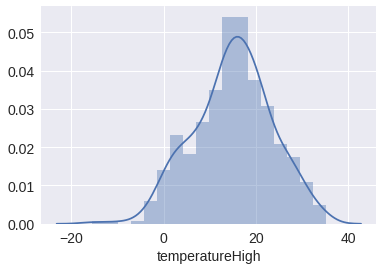

In [9]:
sns.distplot(moves_dataframe['temperatureHigh'])

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


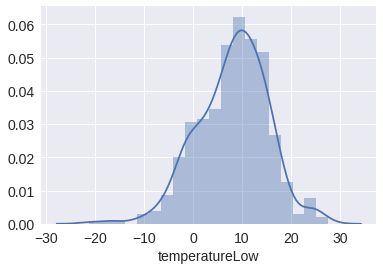

In [10]:
sns.distplot(moves_dataframe['temperatureLow'])

## The impact of temperature (and other factors) on our daily step count

That looks somewhat normally distributed for the temperatures. Let's now look into whether the daily low/high temperatures are correlated with our daily step counts. 

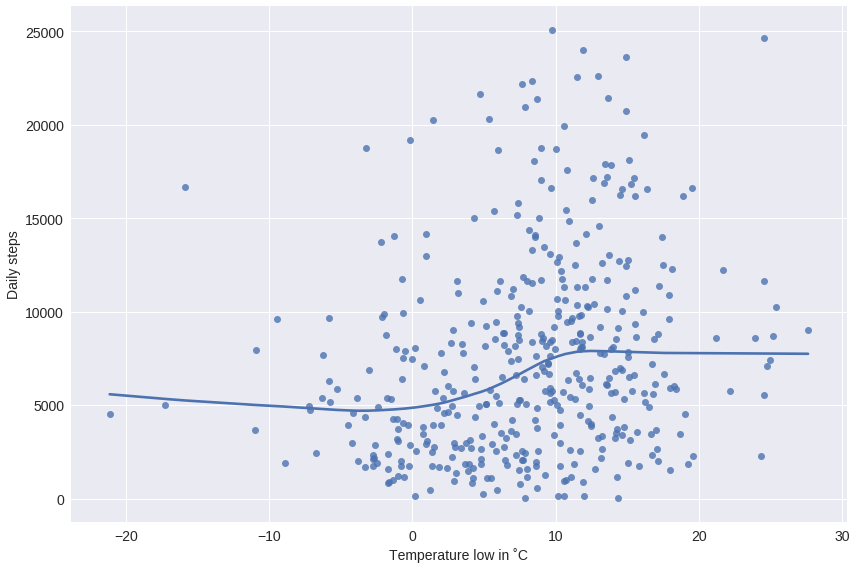

In [11]:
t = sns.lmplot(x="temperatureLow", y="steps", data=moves_dataframe,lowess=True,size=8,aspect=1.5)
t.set(xlabel="Temperature low in ˚C")
t.set(ylabel="Daily steps")

Yep, that looks like both the low temperature (above) and the high temperatures (below) are correlated with our daily step counts, with the daily temperatures of > 10˚C leading to more daily steps. 

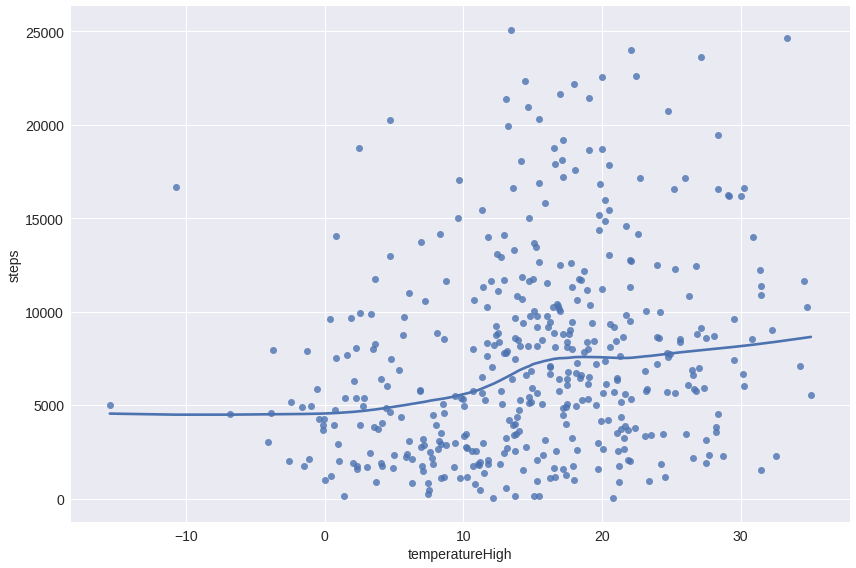

In [12]:
sns.lmplot(x="temperatureHigh", y="steps", data=moves_dataframe,lowess=True,size=8,aspect=1.5)

## other factors influencing step counts
But of course the weather isn't the only factor that might influence our movement patterns. Time itself might be a big influencer. If we look at the average daily step counts below we see some marked differences there. Generally, 2018 seems to be a much more active year for Bastian compared to 2017. Which might be unsurprising, [given that prior research has shown that Bastian's PhD thesis writing negatively impacted his activity](http://ruleofthirds.de/phd-survival-guide/). Which might also explain why 2017 is a bit worse step-count-wise compared to 2016.

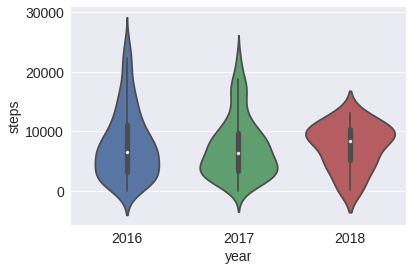

In [13]:
sns.violinplot(x='year',y='steps',data=moves_dataframe)

Let's thus just split up our data by year and see what happens then. And indeed, the data for 2016 looks somewhat different than the one for 2017 and 2018:

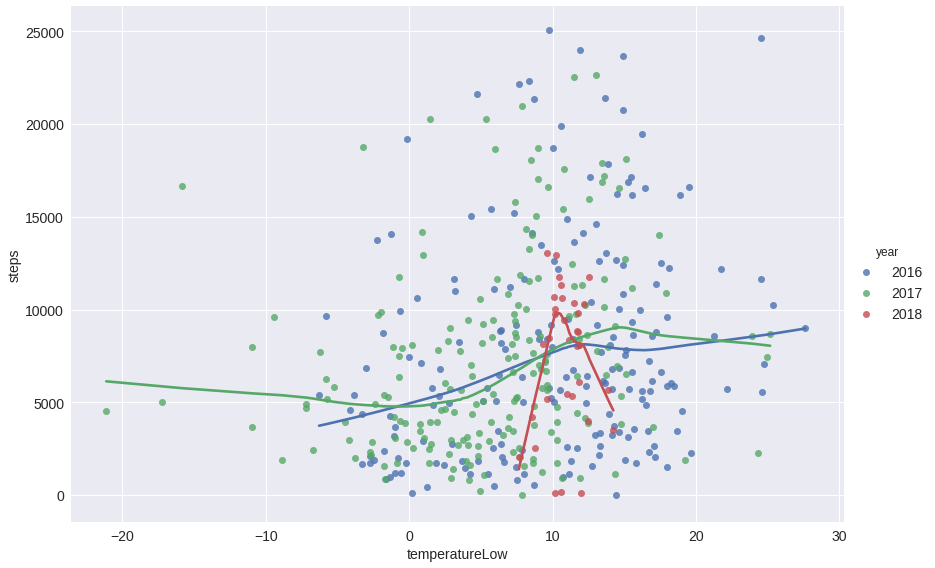

In [14]:
sns.lmplot(x="temperatureLow", y="steps", data=moves_dataframe,lowess=True,hue='year',size=8,aspect=1.5)

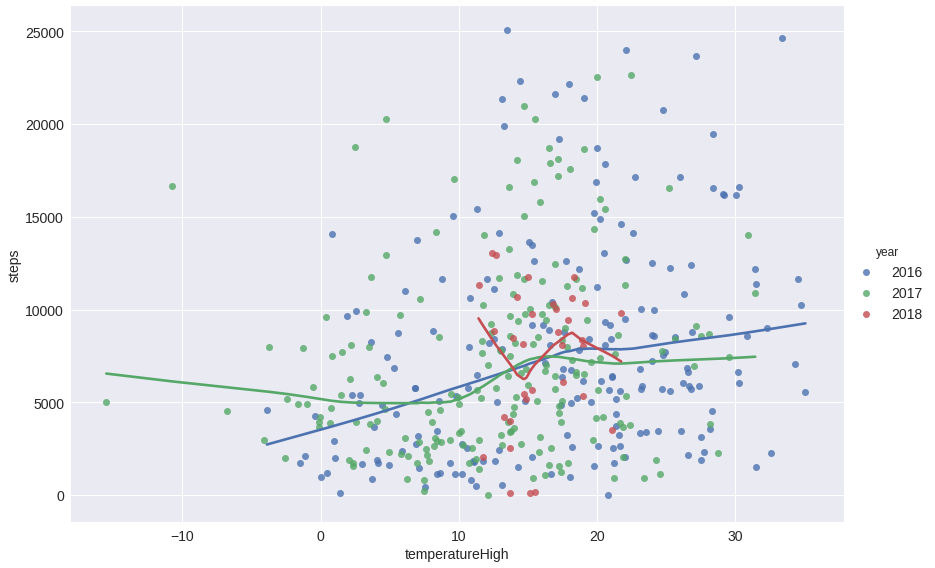

In [15]:
sns.lmplot(x="temperatureHigh", y="steps", data=moves_dataframe,hue='year',lowess=True,size=8,aspect=1.5)

Overall the influence of temperature appears to be rather low. But this might be due to a lot of other external factors besides work-stress, like 
1. traveling abroad
2. moving to a different place with a different step-baseline
3. starting a new job etc. 

One easy way to get around this would be to limit ourselves only to those days in which we were in a given home. This would make sure we haven't moved to another place yet and aren't traveling. 

To do so we specify a target location with `target_latitude` and `target_longitude` and a maximum distance `km_distance` in kilometers from this point which we want to accept. That way we can filter down our data to days in which we e.g. spent in our home city.

For Bastian's data the `target` locations give his old home in Offenbach and a 25 km radius around this, to include his old work place and places of social interactions:

In [16]:
target_latitude = 50.114462 # you can get this e.g. from Google maps
target_longitude = 8.746019 # same for this
km_distance = 25 # we don't want to be too strict in filtering. 

Now we can calculate our boundaries for which days to accept:

In [17]:
# earth's radius in km = ~6371
earth_radius = 6371

# latitude boundaries
maxlat = target_latitude + np.rad2deg(km_distance / earth_radius)
minlat = target_latitude - np.rad2deg(km_distance / earth_radius)

#longitude boundaries (longitude gets smaller when latitude increases)
maxlng = target_longitude + np.rad2deg(km_distance / earth_radius / np.cos(np.deg2rad(target_latitude)))
minlng = target_longitude - np.rad2deg(km_distance / earth_radius / np.cos(np.deg2rad(target_latitude)))

With these boundaries we can now start to filter our complete data set. In addition to the location filter we also filter down the data to days in 2016:

In [18]:
moves_dataframe_home = moves_dataframe[(moves_dataframe['longitude'] >= minlng) & 
                (moves_dataframe['longitude'] < maxlng) &
                (moves_dataframe['latitude'] < maxlat) & 
                (moves_dataframe['latitude'] > minlat) & 
                (moves_dataframe['year'] == '2016')]
print("After filtering the orignal data {} days out of {} days remain in the data set.".format(len(moves_dataframe_home),
                                                                                               len(moves_dataframe)))

After filtering the orignal data 108 days out of 428 days remain in the data set.


Let's now plot the step counts and temperatures again with our reduced data set. Our initially observed, rather small effect of the temperature on the step counts remains present: 

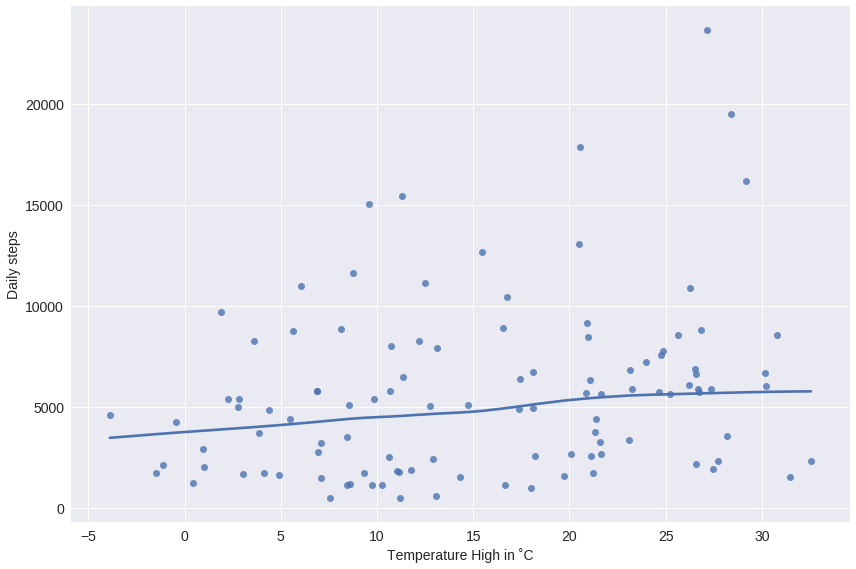

In [19]:
t = sns.lmplot(x="temperatureHigh", y="steps", data=moves_dataframe_home,lowess=True,size=8,aspect=1.5)
t.set(xlabel="Temperature High in ˚C")
t.set(ylabel="Daily steps")

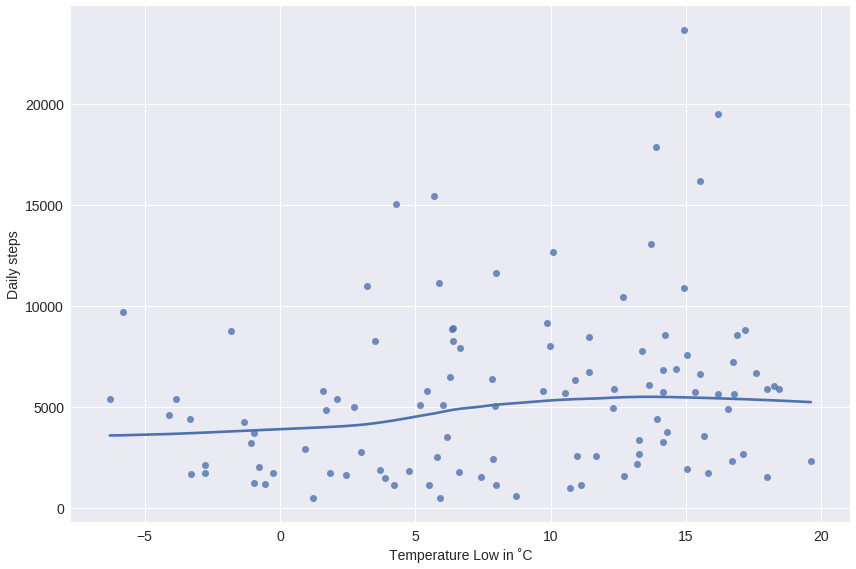

In [20]:
t = sns.lmplot(x="temperatureLow", y="steps", data=moves_dataframe_home,lowess=True,size=8,aspect=1.5)
t.set(xlabel="Temperature Low in ˚C")
t.set(ylabel="Daily steps")

Besides temperature there's a second big potential influencer of daily movement patterns: Precipitation. After all, it's easy to see how rainy weather might make you want to stay inside. Let's quickly compare the categorical presence/absence of precipitation types and daily step counts:

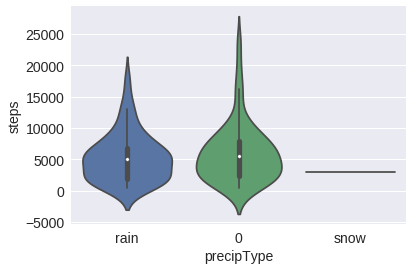

In [21]:
sns.violinplot(x='precipType',y='steps',data=moves_dataframe_home)

That pretty much looks like the presence of rain does not have a major influence on my step counts. We can also perform a quick *Mann-Whitney-U* test to see whether there's a statistically significant difference between these:

In [22]:
from scipy.stats import mannwhitneyu

rain = moves_dataframe_home[moves_dataframe_home['precipType'] == 'rain']
clear = moves_dataframe_home[moves_dataframe_home['precipType'] == 0]
mannwhitneyu(rain['steps'], clear['steps'],alternative='two-sided')

MannwhitneyuResult(statistic=1307.5, pvalue=0.44344399113646915)

With a `pvalue=0.443` we can not find any significant differences here. Which is great: Given how little my step counts are influenced by temperature & precipitation it seems that me being a couch potato is not really a function of the weather. 🎉 

## A small bonus
You can also use Python to map your daily step counts around the planet. If we use the non-filtered data across all years it looks like this: 

(the command might take a good while, as installing the `basemap` package takes a while)

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda:
#
basemap                   1.1.0                    py36_4    conda-forge


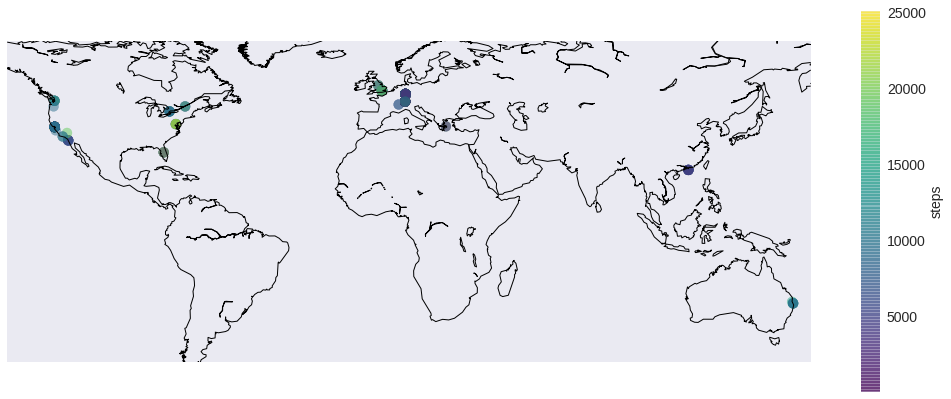

In [23]:
import sys
!conda install --yes --prefix {sys.prefix} basemap
from mpl_toolkits.basemap import Basemap
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,7))
m = Basemap(projection='cyl',llcrnrlat=-50,urcrnrlat=70,\
            llcrnrlon=-140,urcrnrlon=160)
m.drawcoastlines()
m.scatter(moves_dataframe['longitude'],
          moves_dataframe['latitude'],
          latlon=True,
          c= (moves_dataframe['steps']),
          s=100,
          cmap='viridis', alpha=0.5)
plt.colorbar(label='steps')
plt.clim(moves_dataframe['steps'].min(), 
         moves_dataframe['steps'].max())
plt.show()